<a href="https://colab.research.google.com/github/aiswarya-180/Bank-Customer-Churn-Prediction/blob/main/MRP_HyperParameter%2B_Feature_Engineering_%2B_Feature_Selection_%2B_Oversampling_%2B_controlling_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Oversampling + Feature Engineering + Feature Selection + HyperParameter tuning  + controlling overfitting for the top 3 models - Catboost, Xgboost, Lightgbm

In [1]:
!pip install catboost shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [2]:
# mount google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_1 = pd.read_csv('/content/drive/My Drive/MRP/after_EDA.csv')
df_1.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,1,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,0,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,1,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,0,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,1,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [5]:

df_1.shape

(10127, 20)

In [6]:
categorical_cols = df_1.select_dtypes(include=['object']).columns
categorical_cols

Index(['Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')

In [7]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  int64  
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

# Feature Engineering

In [8]:
print("Step 1: Feature Engineering...")
df_eng = df_1.copy()

# Create new features
df_eng['High_Utilization'] = (df_eng['Avg_Utilization_Ratio'] > 0.7).astype(int)
df_eng['Activity_Decline'] = ((df_eng['Total_Ct_Chng_Q4_Q1'] < 0.7) |
                              (df_eng['Total_Amt_Chng_Q4_Q1'] < 0.7)).astype(int)
df_eng['Low_Engagement'] = ((df_eng['Months_Inactive_12_mon'] > 2) &
                            (df_eng['Contacts_Count_12_mon'] < 3)).astype(int)

df_eng['Avg_Transaction_Amount'] = df_eng['Total_Trans_Amt'] / df_eng['Total_Trans_Ct']
df_eng['Credit_Dependency'] = df_eng['Total_Revolving_Bal'] / df_eng['Credit_Limit']
df_eng['High_Value_Customer'] = (df_eng['Total_Trans_Amt'] >
                                 df_eng['Total_Trans_Amt'].quantile(0.75)).astype(int)
df_eng['Multi_Product_User'] = (df_eng['Total_Relationship_Count'] > 3).astype(int)

print(f"Original features: {df_1.shape[1]}")
print(f"After feature engineering: {df_eng.shape[1]}")


Step 1: Feature Engineering...
Original features: 20
After feature engineering: 27


In [9]:
df_eng.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,High_Utilization,Activity_Decline,Low_Engagement,Avg_Transaction_Amount,Credit_Dependency,High_Value_Customer,Multi_Product_User
0,0,45,1,3,High School,Married,$60K - $80K,Blue,39,5,...,42,1.625,0.061,0,0,0,27.238095,0.061224,0,1
1,0,49,0,5,Graduate,Single,Less than $40K,Blue,44,6,...,33,3.714,0.105,0,0,0,39.121212,0.104651,0,1
2,0,51,1,3,Graduate,Married,$80K - $120K,Blue,36,4,...,20,2.333,0.000,0,0,0,94.350000,0.000000,0,1
3,0,40,0,4,High School,Unknown,Less than $40K,Blue,34,3,...,20,2.333,0.760,1,0,1,58.550000,0.759734,0,0
4,0,40,1,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,28,2.500,0.000,0,0,0,29.142857,0.000000,0,1


In [10]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  int64  
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

# Catboost with SMOTENC & Label Encoding


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ===== 1. Split features and target =====
X_cat = df_eng.drop("Attrition_Flag", axis=1)
y_cat = df_eng["Attrition_Flag"]

# ===== 2. Train-test split =====
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

# ===== 3. Label encoding =====
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train_cat[col] = le.fit_transform(X_train_cat[col].astype(str))
    X_test_cat[col] = le.transform(X_test_cat[col].astype(str))
    label_encoders[col] = le

# ===== 4. SMOTENC oversampling =====
cat_col_indices = [X_train_cat.columns.get_loc(col) for col in categorical_cols]
X_train_np = X_train_cat.values

smote_nc = SMOTENC(categorical_features=cat_col_indices, random_state=42)
X_train_res, y_train_res = smote_nc.fit_resample(X_train_np, y_train_cat)

feature_names = X_train_cat.columns.tolist()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ===== 5. RFECV Feature Selection =====
catboost_estimator = CatBoostClassifier(verbose=0, random_state=42, iterations=100)

rfecv_catboost = RFECV(
    estimator=catboost_estimator,
    step=1,
    cv=cv,
    scoring='recall',
    min_features_to_select=5,
    n_jobs=-1,
    verbose=1
)

rfecv_catboost.fit(X_train_res, y_train_res)

selected_mask = rfecv_catboost.support_
selected_features_catboost = [feature_names[i] for i, keep in enumerate(selected_mask) if keep]

print(f"Optimal number of features selected: {rfecv_catboost.n_features_}")
print(f"Best CV recall: {max(rfecv_catboost.cv_results_['mean_test_score']):.4f}")
print(f"Selected features: {selected_features_catboost}")

# ===== 6. Prepare selected features =====
X_train_res_df = pd.DataFrame(X_train_res, columns=feature_names)
X_train_selected_df = X_train_res_df[selected_features_catboost].copy()
X_test_selected_df = X_test_cat[selected_features_catboost].copy()

# Ensure categorical columns are int
for col in categorical_cols:
    if col in selected_features_catboost:
        X_train_selected_df[col] = X_train_selected_df[col].astype(int)
        X_test_selected_df[col] = X_test_selected_df[col].astype(int)

# New indices for selected categorical features
cat_features_selected_indices = [
    i for i, col in enumerate(selected_features_catboost) if col in categorical_cols
]

# ===== 7. Hyperparameter Tuning =====
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [300, 500, 800],
    'border_count': [32, 64, 128],
    'random_strength': [0.5, 1.0, 1.5],
    'bagging_temperature': [0, 0.5, 1],
    'verbose': [0]
}

catboost_base = CatBoostClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=catboost_base,
    param_distributions=param_dist,
    n_iter=25,
    scoring='recall',
    cv=cv,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_selected_df, y_train_res, cat_features=cat_features_selected_indices)

best_cat_model = random_search.best_estimator_
print("\nBest Hyperparameters:")
print(random_search.best_params_)

# ===== 8. Final Evaluation on Test Set =====
y_pred_tuned = best_cat_model.predict(X_test_selected_df)
y_proba_tuned = best_cat_model.predict_proba(X_test_selected_df)[:, 1]

print("\n--- TUNED CATBOOST CLASSIFICATION REPORT ---")
print(classification_report(y_test_cat, y_pred_tuned))

# ===== 9. Store Results =====
all_results = {}

all_results['CatBoost_Tuned'] = {
    'features': len(selected_features_catboost),
    'cv_recall': random_search.best_score_,
    'accuracy': accuracy_score(y_test_cat, y_pred_tuned),
    'precision': precision_score(y_test_cat, y_pred_tuned),
    'recall': recall_score(y_test_cat, y_pred_tuned),
    'f1': f1_score(y_test_cat, y_pred_tuned),
    'auc': roc_auc_score(y_test_cat, y_proba_tuned),
    'selected_features': selected_features_catboost,
    'best_params': random_search.best_params_
}

# ===== 10. Final Output =====
print("\n--- CATBOOST TUNED MODEL RESULTS ---")
print(f"Selected Features ({len(selected_features_catboost)}): {selected_features_catboost}\n")
print(classification_report(y_test_cat, y_pred_tuned))


Fitting estimator with 26 features.
Optimal number of features selected: 25
Best CV recall: 0.9856
Selected features: ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'High_Utilization', 'Activity_Decline', 'Low_Engagement', 'Avg_Transaction_Amount', 'Credit_Dependency', 'High_Value_Customer', 'Multi_Product_User']
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Hyperparameters:
{'verbose': 0, 'random_strength': 1.0, 'learning_rate': 0.2, 'l2_leaf_reg': 5, 'iterations': 800, 'depth': 10, 'border_count': 64, 'bagging_temperature': 1}

--- TUNED CATBOOST CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.97

In [ ]:
y_pred_train_tuned = best_cat_model.predict(X_train_selected_df)
print("\n--- CATBOOST CLASSIFICATION REPORT (Train, Tuned) ---")
print(classification_report(y_train_res, y_pred_train_tuned))



--- CATBOOST CLASSIFICATION REPORT (Train, Tuned) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6799
           1       1.00      1.00      1.00      6799

    accuracy                           1.00     13598
   macro avg       1.00      1.00      1.00     13598
weighted avg       1.00      1.00      1.00     13598



In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X_train_selected_df, y_train_res, X_test_selected_df, y_test_cat are ready as per your pipeline

# Further split the resampled training data into a training and validation set for early stopping
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_selected_df, y_train_res, test_size=0.2, random_state=42, stratify=y_train_res
)

# CatBoost model with increased regularization and early stopping
final_cat_model = CatBoostClassifier(
    iterations=1000,
    depth=5,              # Reduced depth to limit complexity
    l2_leaf_reg=5,        # Increased L2 regularization
    learning_rate=0.05,   # Reduced learning rate for more stable learning
    random_seed=42,
    verbose=100           # Verbose output to monitor training progress
)

final_cat_model.fit(
    X_train_final,
    y_train_final,
    eval_set=(X_val_final, y_val_final),
    cat_features=cat_features_selected_indices,
    early_stopping_rounds=50,  # Stop if validation metric does not improve for 50 rounds
    use_best_model=True        # Use the best iteration for prediction
)

# Predict on test set
y_pred_cat = final_cat_model.predict(X_test_selected_df)
y_pred_proba_cat = final_cat_model.predict_proba(X_test_selected_df)[:, 1]

print("\n--- CATBOOST CLASSIFICATION REPORT (Test, After Regularization & Early Stopping) ---")
print(classification_report(y_test_cat, y_pred_cat))

# Also check train/validation performance for overfitting signs
y_pred_train = final_cat_model.predict(X_train_final)
print("\n--- CATBOOST CLASSIFICATION REPORT (Train subset) ---")
print(classification_report(y_train_final, y_pred_train))

y_pred_val = final_cat_model.predict(X_val_final)
print("\n--- CATBOOST CLASSIFICATION REPORT (Validation subset) ---")
print(classification_report(y_val_final, y_pred_val))


0:	learn: 0.6294352	test: 0.6297478	best: 0.6297478 (0)	total: 58.7ms	remaining: 58.7s
100:	learn: 0.0865003	test: 0.0943423	best: 0.0943423 (100)	total: 4.59s	remaining: 40.8s
200:	learn: 0.0559072	test: 0.0686078	best: 0.0686078 (200)	total: 9.05s	remaining: 36s
300:	learn: 0.0400816	test: 0.0568283	best: 0.0568283 (300)	total: 11s	remaining: 25.6s
400:	learn: 0.0327074	test: 0.0520914	best: 0.0520912 (399)	total: 14.6s	remaining: 21.9s
500:	learn: 0.0280436	test: 0.0493213	best: 0.0493213 (500)	total: 16.9s	remaining: 16.8s
600:	learn: 0.0241507	test: 0.0473222	best: 0.0472915 (592)	total: 18.8s	remaining: 12.5s
700:	learn: 0.0209826	test: 0.0458498	best: 0.0458380 (696)	total: 20.7s	remaining: 8.85s
800:	learn: 0.0184204	test: 0.0449632	best: 0.0449230 (799)	total: 22.6s	remaining: 5.62s
900:	learn: 0.0165454	test: 0.0443589	best: 0.0443589 (900)	total: 24.6s	remaining: 2.7s
999:	learn: 0.0147953	test: 0.0439151	best: 0.0439151 (999)	total: 27.5s	remaining: 0us

bestTest = 0.043915

In [ ]:
from sklearn.model_selection import train_test_split

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_selected_df, y_train_res, test_size=0.2, random_state=42, stratify=y_train_res
)

final_cat_model = CatBoostClassifier(
    iterations=2000,
    depth=4,
    learning_rate=0.01,
    l2_leaf_reg=10,
    random_seed=42,
    verbose=100
)

final_cat_model.fit(
    X_train_final,
    y_train_final,
    eval_set=(X_val_final, y_val_final),
    early_stopping_rounds=50,
    cat_features=cat_features_selected_indices,
    use_best_model=True
)

# Predict on test set
y_pred_cat = final_cat_model.predict(X_test_selected_df)
y_pred_proba_cat = final_cat_model.predict_proba(X_test_selected_df)[:, 1]

print("\n--- CATBOOST CLASSIFICATION REPORT (Test, After Regularization & Early Stopping) ---")
print(classification_report(y_test_cat, y_pred_cat))

# Also check train/validation performance for overfitting signs
y_pred_train = final_cat_model.predict(X_train_final)
print("\n--- CATBOOST CLASSIFICATION REPORT (Train subset) ---")
print(classification_report(y_train_final, y_pred_train))

y_pred_val = final_cat_model.predict(X_val_final)
print("\n--- CATBOOST CLASSIFICATION REPORT (Validation subset) ---")
print(classification_report(y_val_final, y_pred_val))


0:	learn: 0.6816383	test: 0.6817859	best: 0.6817859 (0)	total: 42.4ms	remaining: 1m 24s
100:	learn: 0.2777025	test: 0.2837643	best: 0.2837643 (100)	total: 3.15s	remaining: 59.2s
200:	learn: 0.1902732	test: 0.1972249	best: 0.1972249 (200)	total: 5.46s	remaining: 48.9s
300:	learn: 0.1484722	test: 0.1552189	best: 0.1552189 (300)	total: 7.79s	remaining: 44s
400:	learn: 0.1239545	test: 0.1305045	best: 0.1305045 (400)	total: 10.8s	remaining: 42.9s
500:	learn: 0.1074618	test: 0.1142052	best: 0.1142052 (500)	total: 12.4s	remaining: 37.1s
600:	learn: 0.0965650	test: 0.1033312	best: 0.1033312 (600)	total: 14s	remaining: 32.7s
700:	learn: 0.0872758	test: 0.0942953	best: 0.0942953 (700)	total: 15.7s	remaining: 29.1s
800:	learn: 0.0801053	test: 0.0875076	best: 0.0875076 (800)	total: 17.3s	remaining: 25.9s
900:	learn: 0.0747506	test: 0.0825594	best: 0.0825594 (900)	total: 19s	remaining: 23.1s
1000:	learn: 0.0696327	test: 0.0780131	best: 0.0780131 (1000)	total: 20.8s	remaining: 20.8s
1100:	learn: 0.0

with reduced overfitting(gives gud rslt than best param)

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Optimal number of features selected: 21
Best CV recall (RFECV): 0.9759
Selected features: ['Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Activity_Decline', 'Low_Engagement', 'Avg_Transaction_Amount', 'Credit_Dependency', 'High_Value_Customer', 'Multi_Product_User']


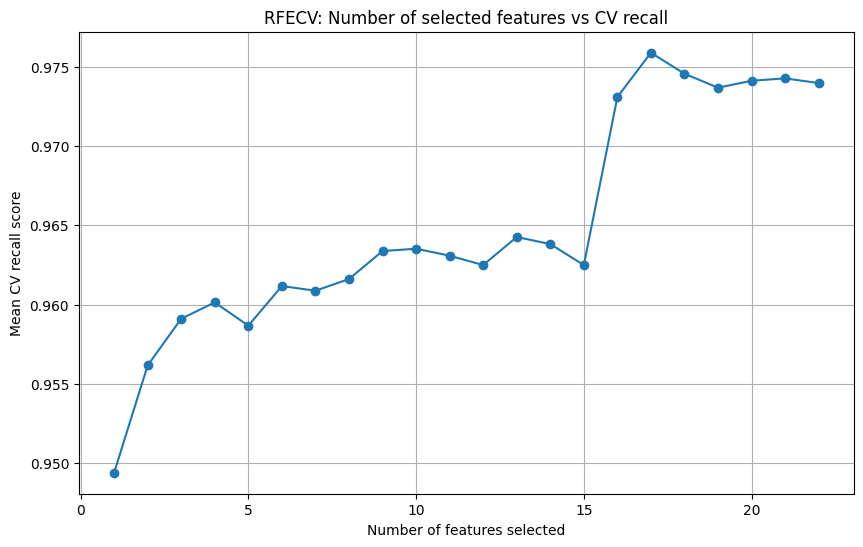


--- Fold 1 ---
0:	learn: 0.6834511	test: 0.6832322	best: 0.6832322 (0)	total: 7.18ms	remaining: 14.4s
100:	learn: 0.2841826	test: 0.2791841	best: 0.2791841 (100)	total: 554ms	remaining: 10.4s
200:	learn: 0.1925919	test: 0.1904227	best: 0.1904227 (200)	total: 1.13s	remaining: 10.1s
300:	learn: 0.1501856	test: 0.1499980	best: 0.1499980 (300)	total: 1.68s	remaining: 9.46s
400:	learn: 0.1262505	test: 0.1271544	best: 0.1271544 (400)	total: 2.24s	remaining: 8.92s
500:	learn: 0.1098273	test: 0.1114110	best: 0.1114110 (500)	total: 2.78s	remaining: 8.31s
600:	learn: 0.0969092	test: 0.0989838	best: 0.0989838 (600)	total: 4.1s	remaining: 9.54s
700:	learn: 0.0875249	test: 0.0898952	best: 0.0898952 (700)	total: 5.6s	remaining: 10.4s
800:	learn: 0.0804987	test: 0.0832948	best: 0.0832948 (800)	total: 7.01s	remaining: 10.5s
900:	learn: 0.0752518	test: 0.0786013	best: 0.0786013 (900)	total: 7.57s	remaining: 9.24s
1000:	learn: 0.0701167	test: 0.0739311	best: 0.0739311 (1000)	total: 8.11s	remaining: 8.0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Prepare data ---
X = df_eng.drop("Attrition_Flag", axis=1).copy()
y = df_eng["Attrition_Flag"].copy()

# --- 2. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# --- 3. Label Encode categorical features ---
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

cat_col_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

# --- 4. SMOTENC oversampling on training data ---
smote_nc = SMOTENC(categorical_features=cat_col_indices, random_state=42)
X_train_np = X_train.values
X_train_res, y_train_res = smote_nc.fit_resample(X_train_np, y_train)

feature_names = X_train.columns.tolist()

# --- 5. RFECV Feature Selection ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

catboost_estimator = CatBoostClassifier(
    verbose=0,
    random_seed=42,
    iterations=100,
    depth=6,
    l2_leaf_reg=3
)

rfecv = RFECV(
    estimator=catboost_estimator,
    step=1,
    cv=cv,
    scoring='recall',
    min_features_to_select=5,
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train_res, y_train_res)

selected_mask = rfecv.support_
selected_features = [feature_names[i] for i, keep in enumerate(selected_mask) if keep]

print(f"Optimal number of features selected: {rfecv.n_features_}")
print(f"Best CV recall (RFECV): {max(rfecv.cv_results_['mean_test_score']):.4f}")
print(f"Selected features: {selected_features}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.title("RFECV: Number of selected features vs CV recall")
plt.xlabel("Number of features selected")
plt.ylabel("Mean CV recall score")
plt.grid(True)
plt.show()


# Convert resampled training data back to DataFrame with selected features
X_train_res_df = pd.DataFrame(X_train_res, columns=feature_names)
X_train_selected = X_train_res_df[selected_features].copy()

# Select features on original test set
X_test_selected = X_test[selected_features].copy()

# Ensure categorical features are int types for CatBoost
for col in categorical_cols:
    if col in selected_features:
        X_train_selected[col] = X_train_selected[col].astype(int)
        X_test_selected[col] = X_test_selected[col].astype(int)

# Get new categorical feature indices after feature selection
cat_features_selected_idx = [i for i, col in enumerate(selected_features) if col in categorical_cols]

# --- 6. Stratified K-Fold Cross Validation with Early Stopping to train final model ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
validation_scores = []

models = []  # to keep models from each fold if you want

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_selected, y_train_res), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_val = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_tr, y_val = y_train_res.iloc[train_idx], y_train_res.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=2000,
        depth=4,
        learning_rate=0.01,
        l2_leaf_reg=10,
        random_seed=42,
        early_stopping_rounds=50,
        verbose=100
    )
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        cat_features=cat_features_selected_idx,
        use_best_model=True
    )

    y_val_pred = model.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred)
    validation_scores.append(val_f1)
    print(f"Fold {fold} Validation F1-score: {val_f1:.4f}")

    models.append(model)

print(f"\nAverage Validation F1-score across folds: {np.mean(validation_scores):.4f}")

# --- 7. Train final model on all resampled training data with early stopping and best iteration ---
final_model = CatBoostClassifier(
    iterations=2000,
    depth=4,
    learning_rate=0.01,
    l2_leaf_reg=10,
    random_seed=42,
    verbose=100
)

# For early stopping on full training, split off a small validation set:
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
    X_train_selected,
    y_train_res,
    test_size=0.1,
    random_state=42,
    stratify=y_train_res
)

final_model.fit(
    X_tr_final, y_tr_final,
    eval_set=(X_val_final, y_val_final),
    cat_features=cat_features_selected_idx,
    early_stopping_rounds=50,
    use_best_model=True
)

# --- 8. Evaluation on training, validation, and test ---

print("\n--- Training Set Classification Report ---")
y_train_pred = final_model.predict(X_tr_final)
print(classification_report(y_tr_final, y_train_pred))

print("\n--- Validation Set Classification Report ---")
y_val_pred = final_model.predict(X_val_final)
print(classification_report(y_val_final, y_val_pred))

print("\n--- Test Set Classification Report ---")
y_test_pred = final_model.predict(X_test_selected)
y_test_proba = final_model.predict_proba(X_test_selected)[:,1]
print(classification_report(y_test, y_test_pred))

print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred):.4f}")

# --- 9. Save and display all important outputs ---
all_results = {
    'features_selected': selected_features,
    'best_rfecv_cv_recall': max(rfecv.cv_results_['mean_test_score']),
    'validation_f1_mean': np.mean(validation_scores),
    'test_accuracy': accuracy_score(y_test, y_test_pred),
    'test_precision': precision_score(y_test, y_test_pred),
    'test_recall': recall_score(y_test, y_test_pred),
    'test_f1': f1_score(y_test, y_test_pred),
    'test_auc': roc_auc_score(y_test, y_test_proba),
}

print("\n--- Summary of Results ---")
for k,v in all_results.items():
    if isinstance(v, list):
        print(f"{k}: {v}")
    else:
        print(f"{k}: {v:.4f}")


# overfitting ctrld + best params

Optimal number of features selected: 26
Best CV recall (RFECV): 0.9785
Selected features: ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'High_Utilization', 'Activity_Decline', 'Low_Engagement', 'Avg_Transaction_Amount', 'Credit_Dependency', 'High_Value_Customer', 'Multi_Product_User']


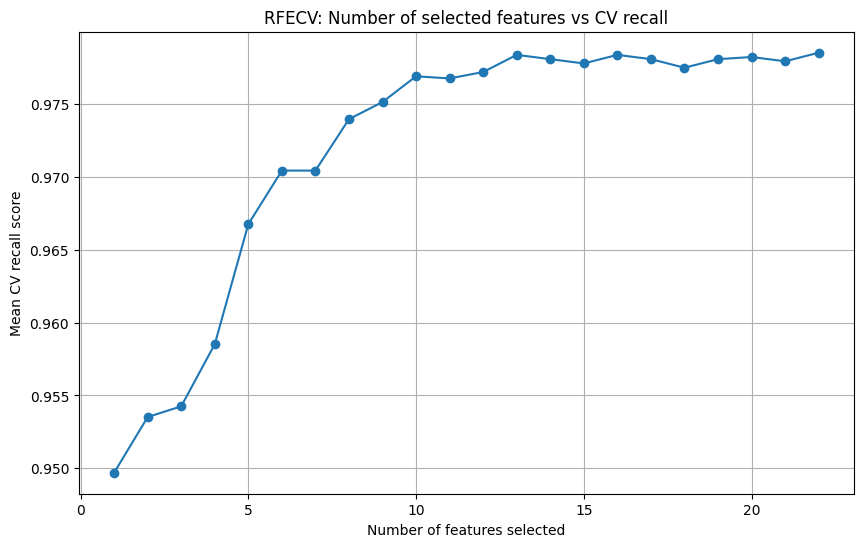


--- Fold 1 ---
0:	learn: 0.6825123	test: 0.6818395	best: 0.6818395 (0)	total: 31.6ms	remaining: 1m 3s
100:	learn: 0.2853563	test: 0.2801095	best: 0.2801095 (100)	total: 2.18s	remaining: 41s
200:	learn: 0.1943172	test: 0.1922181	best: 0.1922181 (200)	total: 3.57s	remaining: 32s
300:	learn: 0.1495917	test: 0.1491782	best: 0.1491782 (300)	total: 5.02s	remaining: 28.3s
400:	learn: 0.1257311	test: 0.1264003	best: 0.1264003 (400)	total: 6.41s	remaining: 25.6s
500:	learn: 0.1091653	test: 0.1103549	best: 0.1103549 (500)	total: 7.84s	remaining: 23.5s
600:	learn: 0.0971562	test: 0.0986766	best: 0.0986766 (600)	total: 9.26s	remaining: 21.6s
700:	learn: 0.0889419	test: 0.0909493	best: 0.0909493 (700)	total: 10.6s	remaining: 19.7s
800:	learn: 0.0820135	test: 0.0845765	best: 0.0845765 (800)	total: 12.5s	remaining: 18.7s
900:	learn: 0.0765310	test: 0.0794509	best: 0.0794509 (900)	total: 15.1s	remaining: 18.4s
1000:	learn: 0.0718450	test: 0.0752989	best: 0.0752989 (1000)	total: 16.5s	remaining: 16.4s

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Prepare data ---
X = df_eng.drop("Attrition_Flag", axis=1).copy()
y = df_eng["Attrition_Flag"].copy()

# --- 2. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# --- 3. Label Encode categorical features ---
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

cat_col_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

# --- 4. SMOTENC oversampling on training data ---
smote_nc = SMOTENC(categorical_features=cat_col_indices, random_state=42)
X_train_np = X_train.values
X_train_res, y_train_res = smote_nc.fit_resample(X_train_np, y_train)

feature_names = X_train.columns.tolist()

# --- 5. RFECV Feature Selection ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

catboost_estimator = CatBoostClassifier(
    verbose=0,            # Suppress training output for cleaner logs; set >0 to monitor training
    random_seed=42,       # Ensure reproducibility
    iterations=1000,      # Increase iterations for potentially better learning (early stopping can prevent overfitting)
    depth=4,              # Slightly reduced depth to reduce model complexity and overfitting risk
    l2_leaf_reg=10,       # Increase L2 regularization for better generalization
    learning_rate=0.01,   # Lower learning rate for more stable convergence
    # early_stopping_rounds=50 # Note: early stopping is effective but must be used when you have validation data in .fit()
)

rfecv = RFECV(
    estimator=catboost_estimator,
    step=1,
    cv=cv,
    scoring='recall',
    min_features_to_select=5,
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train_res, y_train_res)

selected_mask = rfecv.support_
selected_features = [feature_names[i] for i, keep in enumerate(selected_mask) if keep]

print(f"Optimal number of features selected: {rfecv.n_features_}")
print(f"Best CV recall (RFECV): {max(rfecv.cv_results_['mean_test_score']):.4f}")
print(f"Selected features: {selected_features}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.title("RFECV: Number of selected features vs CV recall")
plt.xlabel("Number of features selected")
plt.ylabel("Mean CV recall score")
plt.grid(True)
plt.show()


# Convert resampled training data back to DataFrame with selected features
X_train_res_df = pd.DataFrame(X_train_res, columns=feature_names)
X_train_selected = X_train_res_df[selected_features].copy()

# Select features on original test set
X_test_selected = X_test[selected_features].copy()

# Ensure categorical features are int types for CatBoost
for col in categorical_cols:
    if col in selected_features:
        X_train_selected[col] = X_train_selected[col].astype(int)
        X_test_selected[col] = X_test_selected[col].astype(int)

# Get new categorical feature indices after feature selection
cat_features_selected_idx = [i for i, col in enumerate(selected_features) if col in categorical_cols]

# --- 6. Stratified K-Fold Cross Validation with Early Stopping to train final model ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
validation_scores = []

models = []  # to keep models from each fold if you want

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_selected, y_train_res), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_val = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_tr, y_val = y_train_res.iloc[train_idx], y_train_res.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=2000,
        depth=4,
        learning_rate=0.01,
        l2_leaf_reg=10,
        random_seed=42,
        early_stopping_rounds=50,
        verbose=100
    )
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        cat_features=cat_features_selected_idx,
        use_best_model=True
    )

    y_val_pred = model.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred)
    validation_scores.append(val_f1)
    print(f"Fold {fold} Validation F1-score: {val_f1:.4f}")

    models.append(model)

print(f"\nAverage Validation F1-score across folds: {np.mean(validation_scores):.4f}")

# --- 7. Train final model on all resampled training data with early stopping and best iteration ---
final_model = CatBoostClassifier(
    iterations=2000,
    depth=4,
    learning_rate=0.01,
    l2_leaf_reg=10,
    random_seed=42,
    verbose=100
)

# For early stopping on full training, split off a small validation set:
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
    X_train_selected,
    y_train_res,
    test_size=0.1,
    random_state=42,
    stratify=y_train_res
)

final_model.fit(
    X_tr_final, y_tr_final,
    eval_set=(X_val_final, y_val_final),
    cat_features=cat_features_selected_idx,
    early_stopping_rounds=50,
    use_best_model=True
)

# --- 8. Evaluation on training, validation, and test ---

print("\n--- Training Set Classification Report ---")
y_train_pred = final_model.predict(X_tr_final)
print(classification_report(y_tr_final, y_train_pred))

print("\n--- Validation Set Classification Report ---")
y_val_pred = final_model.predict(X_val_final)
print(classification_report(y_val_final, y_val_pred))

print("\n--- Test Set Classification Report ---")
y_test_pred = final_model.predict(X_test_selected)
y_test_proba = final_model.predict_proba(X_test_selected)[:,1]
print(classification_report(y_test, y_test_pred))

print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred):.4f}")

# --- 9. Save and display all important outputs ---
all_results = {
    'features_selected': selected_features,
    'best_rfecv_cv_recall': max(rfecv.cv_results_['mean_test_score']),
    'validation_f1_mean': np.mean(validation_scores),
    'test_accuracy': accuracy_score(y_test, y_test_pred),
    'test_precision': precision_score(y_test, y_test_pred),
    'test_recall': recall_score(y_test, y_test_pred),
    'test_f1': f1_score(y_test, y_test_pred),
    'test_auc': roc_auc_score(y_test, y_test_proba),
}

print("\n--- Summary of Results ---")
for k,v in all_results.items():
    if isinstance(v, list):
        print(f"{k}: {v}")
    else:
        print(f"{k}: {v:.4f}")


### SHAP CatBoost

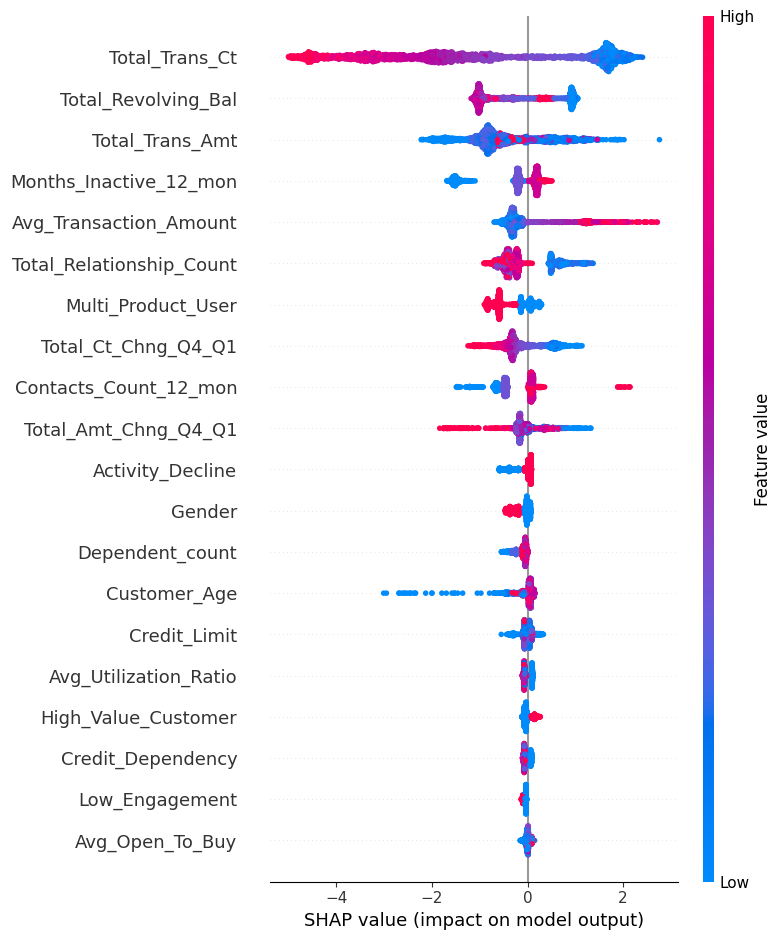

In [ ]:
import shap

# Create a SHAP TreeExplainer for your trained CatBoost model
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values for your test set
shap_values = explainer.shap_values(X_test_selected)
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features)


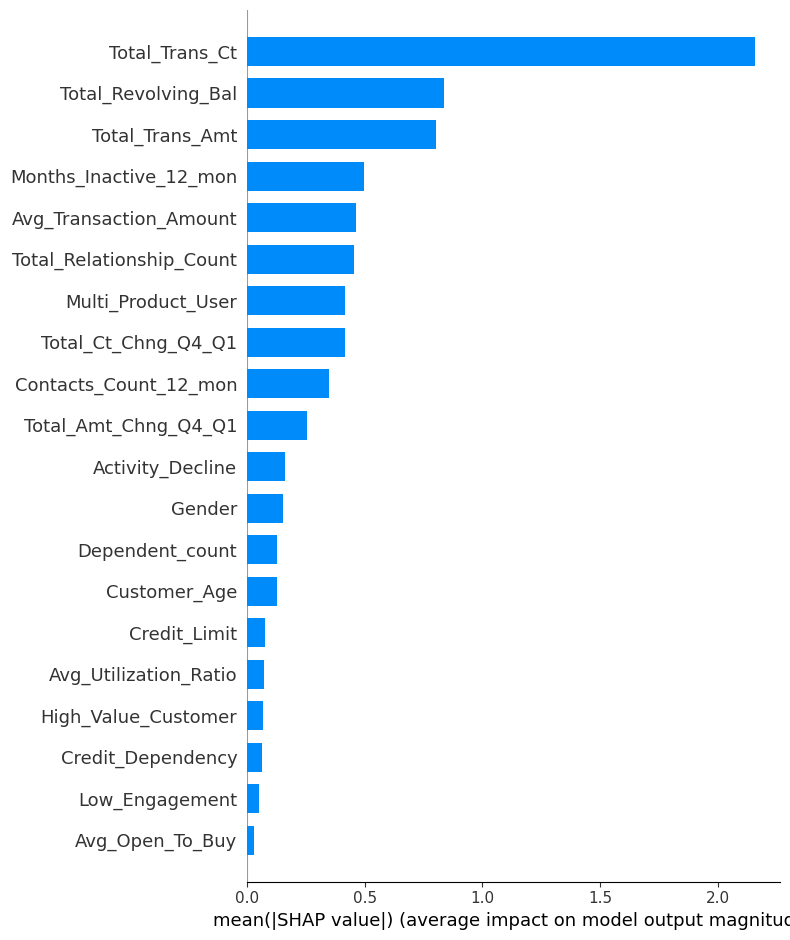

In [ ]:
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features, plot_type="bar")


# One Hot Encoding

In [11]:
# Apply one-hot encoding
df_encoded = pd.get_dummies(df_eng, columns=categorical_cols, drop_first=True)

df_encoded.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,1,3,39,5,1,3,12691.0,777,...,False,False,False,True,False,False,False,False,False,False
1,0,49,0,5,44,6,1,2,8256.0,864,...,True,False,False,False,False,True,False,False,False,False
2,0,51,1,3,36,4,1,0,3418.0,0,...,False,False,False,False,True,False,False,False,False,False
3,0,40,0,4,34,3,4,1,3313.0,2517,...,False,True,False,False,False,True,False,False,False,False
4,0,40,1,3,21,5,1,0,4716.0,0,...,False,False,False,True,False,False,False,False,False,False


# Seperate X & Y

In [12]:
X = df_encoded.drop(columns=['Attrition_Flag'])
y = df_encoded['Attrition_Flag']

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# OverSampling - **SMOTE**

In [14]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [15]:
# Convert to DataFrame if needed
if not isinstance(X_train_smote, pd.DataFrame):
    X_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)

# Scaling

In [ ]:

# Prepare scaled data
scaler = StandardScaler()
X_train_smote_scaled_array = scaler.fit_transform(X_train_smote)
X_train_smote_scaled = pd.DataFrame(X_train_smote_scaled_array, columns=X_train_smote.columns)
X_test_scaled_array = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns)

# Feature Selection & Model

In [16]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [17]:
# Dictionary to store all results
all_results = {}

## Xgboost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

print("\n" + "="*80)
print("2. XGBOOST ALGORITHM")
print("="*80)

# --- RFECV Feature Selection ---
print("\n--- RFECV Feature Selection ---")
rfecv_xgb = RFECV(
    estimator=xgb.XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss'),
    step=1,
    cv=cv,
    scoring='recall',
    min_features_to_select=5,
    n_jobs=-1
)
rfecv_xgb.fit(X_train_smote, y_train_smote)

selected_features_xgb = X_train_smote.columns[rfecv_xgb.support_].tolist()
print(f"Optimal features selected: {rfecv_xgb.n_features_}")
print(f"Best CV recall: {max(rfecv_xgb.cv_results_['mean_test_score']):.4f}")
print(f"Selected features: {selected_features_xgb}")

# --- Prepare train/test data with selected features ---
X_train_xgb = rfecv_xgb.transform(X_train_smote)
X_test_xgb = rfecv_xgb.transform(X_test)

# --- Hyperparameter tuning ---
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

xgb_base = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=25,
    scoring='recall',
    cv=cv,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit random search on selected features
random_search_xgb.fit(X_train_xgb, y_train_smote)

# Best estimator
best_xgb_model = random_search_xgb.best_estimator_

print("\nBest Hyperparameters for XGBoost:")
print(random_search_xgb.best_params_)

# --- Final Evaluation ---
y_pred_xgb = best_xgb_model.predict(X_test_xgb)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test_xgb)[:, 1]

print("\n--- Final Tuned Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

print("\n--- XGBOOST CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred_xgb))

# --- Store results ---
all_results['XGBoost_Tuned'] = {
    'features': rfecv_xgb.n_features_,
    'cv_recall': random_search_xgb.best_score_,
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1': f1_score(y_test, y_pred_xgb),
    'auc': roc_auc_score(y_test, y_pred_proba_xgb),
    'selected_features': selected_features_xgb,
    'best_params': random_search_xgb.best_params_
}



2. XGBOOST ALGORITHM

--- RFECV Feature Selection ---
Optimal features selected: 31
Best CV recall: 0.9888
Selected features: ['Customer_Age', 'Gender', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Activity_Decline', 'Low_Engagement', 'Avg_Transaction_Amount', 'Multi_Product_User', 'Education_Level_Doctorate', 'Education_Level_High School', 'Education_Level_Post-Graduate', 'Education_Level_Uneducated', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Unknown', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 'Card_Category_Gold', 'Card_Category_Platinum']
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Hyperparameters for XGBoost:
{'subsample': 

In [ ]:
!pip install --upgrade xgboost


control overfiting

In [ ]:
X_train_selected = X_train_smote_scaled[selected_features_xgb]
X_test_selected = X_test_scaled[selected_features_xgb]

# Split training data further into train/validation subsets for early stopping monitoring
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_selected,
    y_train_smote,
    test_size=0.1,
    random_state=42,
    stratify=y_train_smote
)

# Prepare DMatrix objects for XGBoost native API
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val_sub, label=y_val_sub)
dtest = xgb.DMatrix(X_test_selected, label=y_test)

# Your best hyperparameters, adapted for native API keys where different
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 7,
    'eta': 0.1,              # learning rate
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'seed': 42,
    'verbosity': 1
}

evals = [(dtrain, 'train'), (dval, 'validation')]

# Train model with early stopping
bst = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

print(f"\nBest iteration according to early stopping: {bst.best_iteration}")

# Function to predict and print classification report
def predict_and_classification_report(model, dmatrix, true_labels, dataset_name):
    y_prob = model.predict(dmatrix, iteration_range=(0, model.best_iteration + 1))
    y_pred = (y_prob > 0.5).astype(int)
    print(f"\n--- {dataset_name} Classification Report ---")
    print(classification_report(true_labels, y_pred))
    auc = roc_auc_score(true_labels, y_prob)
    print(f"{dataset_name} AUC: {auc:.4f}")
    return y_pred, y_prob

# Evaluate on train subset
y_train_pred, y_train_prob = predict_and_classification_report(bst, dtrain, y_train_sub, "Training Set")

# Evaluate on validation subset
y_val_pred, y_val_prob = predict_and_classification_report(bst, dval, y_val_sub, "Validation Set")

# Evaluate on test set
y_test_pred, y_test_prob = predict_and_classification_report(bst, dtest, y_test, "Test Set")

# Optional summary metrics
def print_summary_metrics(y_true, y_pred, y_proba, label):
    accuracy = np.mean(y_true == y_pred)
    auc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{label} Metrics -> Accuracy: {accuracy:.4f} | AUC: {auc:.4f} | F1-score: {f1:.4f}")

print_summary_metrics(y_train_sub, y_train_pred, y_train_prob, "Training Set")
print_summary_metrics(y_val_sub, y_val_pred, y_val_prob, "Validation Set")
print_summary_metrics(y_test, y_test_pred, y_test_prob, "Test Set")

[0]	train-auc:0.97562	validation-auc:0.97261
[50]	train-auc:0.99950	validation-auc:0.99854
[100]	train-auc:0.99992	validation-auc:0.99912
[150]	train-auc:0.99999	validation-auc:0.99924
[200]	train-auc:1.00000	validation-auc:0.99937
[250]	train-auc:1.00000	validation-auc:0.99937
[300]	train-auc:1.00000	validation-auc:0.99938
[334]	train-auc:1.00000	validation-auc:0.99938

Best iteration according to early stopping: 285

--- Training Set Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6119
           1       1.00      1.00      1.00      6119

    accuracy                           1.00     12238
   macro avg       1.00      1.00      1.00     12238
weighted avg       1.00      1.00      1.00     12238

Training Set AUC: 1.0000

--- Validation Set Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       680
           1       0.98    

above model is overfitting the training data

In [ ]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_selected, y_train_smote,
    test_size=0.1,
    stratify=y_train_smote,
    random_state=42
)

# Convert to DMatrix format for xgb.train API
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val_sub, label=y_val_sub)
dtest = xgb.DMatrix(X_test_selected, label=y_test)

# Updated parameters with stronger regularization and lower complexity
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,          # reduced depth
    'eta': 0.01,             # lower learning rate for smoother convergence
    'subsample': 0.6,        # keep randomness
    'colsample_bytree': 0.6,
    'gamma': 0.1,
    'reg_alpha': 0.5,        # increased L1 regularization
    'reg_lambda': 2,         # increased L2 regularization
    'seed': 42,
    'verbosity': 1
}

evals = [(dtrain, 'train'), (dval, 'validation')]

# Train with early stopping rounds to prevent overfitting
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,         # a large number to enable early stopping
    evals=evals,
    early_stopping_rounds=50,     # stop if no improvement in 50 rounds
    verbose_eval=50
)

print(f"\nBest iteration: {bst.best_iteration}")

# Prediction helper
def predict_and_evaluate(bst, dmatrix, y_true, label):
    y_prob = bst.predict(dmatrix, iteration_range=(0, bst.best_iteration + 1))
    y_pred = (y_prob > 0.5).astype(int)
    print(f"\n--- {label} Classification Report ---")
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, y_prob)
    print(f"{label} AUC: {auc:.4f}")
    return y_pred, y_prob

# Evaluate on train, val, test
y_train_pred, y_train_prob = predict_and_evaluate(bst, dtrain, y_train_sub, "Training Subset")
y_val_pred, y_val_prob = predict_and_evaluate(bst, dval, y_val_sub, "Validation Subset")
y_test_pred, y_test_prob = predict_and_evaluate(bst, dtest, y_test, "Test Set")

# Optional summary metrics
def print_summary(y_true, y_pred, y_prob, label):
    accuracy = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n{label} -> Accuracy: {accuracy:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

print_summary(y_train_sub, y_train_pred, y_train_prob, "Training Subset")
print_summary(y_val_sub, y_val_pred, y_val_prob, "Validation Subset")
print_summary(y_test, y_test_pred, y_test_prob, "Test Set")

[0]	train-auc:0.96046	validation-auc:0.96269
[50]	train-auc:0.99227	validation-auc:0.99299
[100]	train-auc:0.99369	validation-auc:0.99423
[150]	train-auc:0.99462	validation-auc:0.99499
[200]	train-auc:0.99544	validation-auc:0.99568
[250]	train-auc:0.99615	validation-auc:0.99628
[300]	train-auc:0.99665	validation-auc:0.99668
[350]	train-auc:0.99720	validation-auc:0.99712
[400]	train-auc:0.99755	validation-auc:0.99734
[450]	train-auc:0.99791	validation-auc:0.99759
[500]	train-auc:0.99815	validation-auc:0.99773
[550]	train-auc:0.99836	validation-auc:0.99793
[600]	train-auc:0.99852	validation-auc:0.99803
[650]	train-auc:0.99868	validation-auc:0.99811
[700]	train-auc:0.99880	validation-auc:0.99819
[750]	train-auc:0.99892	validation-auc:0.99829
[800]	train-auc:0.99902	validation-auc:0.99837
[850]	train-auc:0.99911	validation-auc:0.99845
[900]	train-auc:0.99918	validation-auc:0.99853
[950]	train-auc:0.99924	validation-auc:0.99860
[1000]	train-auc:0.99930	validation-auc:0.99865
[1050]	train-au

above model also overfitting

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import numpy as np

# Updated parameters with stronger regularization and less complexity
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 4,          # reduced depth for less complexity
    'eta': 0.01,             # low learning rate for smooth convergence
    'subsample': 0.6,        # keep randomness to reduce overfitting
    'colsample_bytree': 0.6,
    'gamma': 0.1,
    'reg_alpha': 1.0,        # stronger L1 regularization
    'reg_lambda': 3.0,       # stronger L2 regularization
    'seed': 42,
    'verbosity': 1
}

# Prepare DMatrices from your data subsets
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val_sub, label=y_val_sub)
dtest = xgb.DMatrix(X_test_selected, label=y_test)

evals = [(dtrain, 'train'), (dval, 'validation')]

# Train model with early stopping to automatically control overfitting
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,            # large number to let early stopping do its job
    evals=evals,
    early_stopping_rounds=100,        # more patience to find best iteration
    verbose_eval=50
)

print(f"\nBest iteration: {bst.best_iteration}")

# Helper function to generate predictions and print classification report + AUC
def predict_and_report(model, dmatrix, y_true, name):
    y_prob = model.predict(dmatrix, iteration_range=(0, bst.best_iteration + 1))
    y_pred = (y_prob > 0.5).astype(int)
    print(f"\n--- {name} Classification Report ---")
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, y_prob)
    print(f"{name} AUC: {auc:.4f}")
    return y_pred, y_prob

# Evaluate on all splits
y_train_pred, y_train_prob = predict_and_report(bst, dtrain, y_train_sub, "Training Set")
y_val_pred, y_val_prob = predict_and_report(bst, dval, y_val_sub, "Validation Set")
y_test_pred, y_test_prob = predict_and_report(bst, dtest, y_test, "Test Set")

# Optional summary metrics function
def print_summary(y_true, y_pred, y_prob, label):
    accuracy = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n{label} Summary -> Accuracy: {accuracy:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

print_summary(y_train_sub, y_train_pred, y_train_prob, "Training Set")
print_summary(y_val_sub, y_val_pred, y_val_prob, "Validation Set")
print_summary(y_test, y_test_pred, y_test_prob, "Test Set")


[0]	train-auc:0.94777	validation-auc:0.95152
[50]	train-auc:0.98791	validation-auc:0.98999
[100]	train-auc:0.98967	validation-auc:0.99149
[150]	train-auc:0.99124	validation-auc:0.99268
[200]	train-auc:0.99240	validation-auc:0.99365
[250]	train-auc:0.99341	validation-auc:0.99446
[300]	train-auc:0.99427	validation-auc:0.99519
[350]	train-auc:0.99515	validation-auc:0.99588
[400]	train-auc:0.99565	validation-auc:0.99623
[450]	train-auc:0.99618	validation-auc:0.99654
[500]	train-auc:0.99653	validation-auc:0.99677
[550]	train-auc:0.99687	validation-auc:0.99703
[600]	train-auc:0.99714	validation-auc:0.99718
[650]	train-auc:0.99740	validation-auc:0.99733
[700]	train-auc:0.99759	validation-auc:0.99739
[750]	train-auc:0.99778	validation-auc:0.99756
[800]	train-auc:0.99796	validation-auc:0.99767
[850]	train-auc:0.99810	validation-auc:0.99777
[900]	train-auc:0.99823	validation-auc:0.99788
[950]	train-auc:0.99833	validation-auc:0.99800
[1000]	train-auc:0.99843	validation-auc:0.99806
[1050]	train-au

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X_train_selected, y_train_smote, X_test_selected, y_test, and selected_features_xgb are ready

# Further split training data for early stopping validation set
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_selected,
    y_train_smote,
    test_size=0.1,
    stratify=y_train_smote,
    random_state=42
)

# Prepare DMatrix for XGBoost's native API
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val_sub, label=y_val_sub)
dtest = xgb.DMatrix(X_test_selected, label=y_test)

# Updated parameters to reduce overfitting further
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 4,          # lowered depth for less complexity
    'eta': 0.005,            # lower learning rate for smoother learning
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'gamma': 0.1,
    'reg_alpha': 1.0,        # stronger L1 regularization
    'reg_lambda': 3.0,       # stronger L2 regularization
    'seed': 42,
    'verbosity': 1,
}

evals = [(dtrain, 'train'), (dval, 'validation')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,         # large number to let early stopping do its work
    evals=evals,
    early_stopping_rounds=100,     # increased patience
    verbose_eval=50,
)

print(f"\nBest iteration: {bst.best_iteration}")

def predict_and_report(model, dmatrix, y_true, dataset_name):
    y_prob = model.predict(dmatrix, iteration_range=(0, bst.best_iteration + 1))
    y_pred = (y_prob > 0.5).astype(int)
    print(f"\n--- {dataset_name} Classification Report ---")
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, y_prob)
    print(f"{dataset_name} AUC: {auc:.4f}")
    return y_pred, y_prob

y_train_pred, y_train_prob = predict_and_report(bst, dtrain, y_train_sub, "Training Set")
y_val_pred, y_val_prob = predict_and_report(bst, dval, y_val_sub, "Validation Set")
y_test_pred, y_test_prob = predict_and_report(bst, dtest, y_test, "Test Set")

def print_summary(y_true, y_pred, y_prob, label):
    accuracy = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n{label} Summary -> Accuracy: {accuracy:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

print_summary(y_train_sub, y_train_pred, y_train_prob, "Training Set")
print_summary(y_val_sub, y_val_pred, y_val_prob, "Validation Set")
print_summary(y_test, y_test_pred, y_test_prob, "Test Set")


[0]	train-auc:0.90380	validation-auc:0.88494
[50]	train-auc:0.98896	validation-auc:0.98997
[100]	train-auc:0.99007	validation-auc:0.99091
[150]	train-auc:0.99055	validation-auc:0.99127
[200]	train-auc:0.99135	validation-auc:0.99192
[250]	train-auc:0.99227	validation-auc:0.99268
[300]	train-auc:0.99320	validation-auc:0.99352
[350]	train-auc:0.99385	validation-auc:0.99413
[400]	train-auc:0.99446	validation-auc:0.99465
[450]	train-auc:0.99497	validation-auc:0.99516
[500]	train-auc:0.99541	validation-auc:0.99553
[550]	train-auc:0.99581	validation-auc:0.99589
[600]	train-auc:0.99614	validation-auc:0.99619
[650]	train-auc:0.99644	validation-auc:0.99640
[700]	train-auc:0.99666	validation-auc:0.99659
[750]	train-auc:0.99689	validation-auc:0.99679
[800]	train-auc:0.99707	validation-auc:0.99696
[850]	train-auc:0.99725	validation-auc:0.99707
[900]	train-auc:0.99741	validation-auc:0.99721
[950]	train-auc:0.99755	validation-auc:0.99733
[1000]	train-auc:0.99769	validation-auc:0.99750
[1050]	train-au

 latest model is well-regularized and performs excellently, with manageable and expected overfitting considering data complexity

### SHAP XGBoost

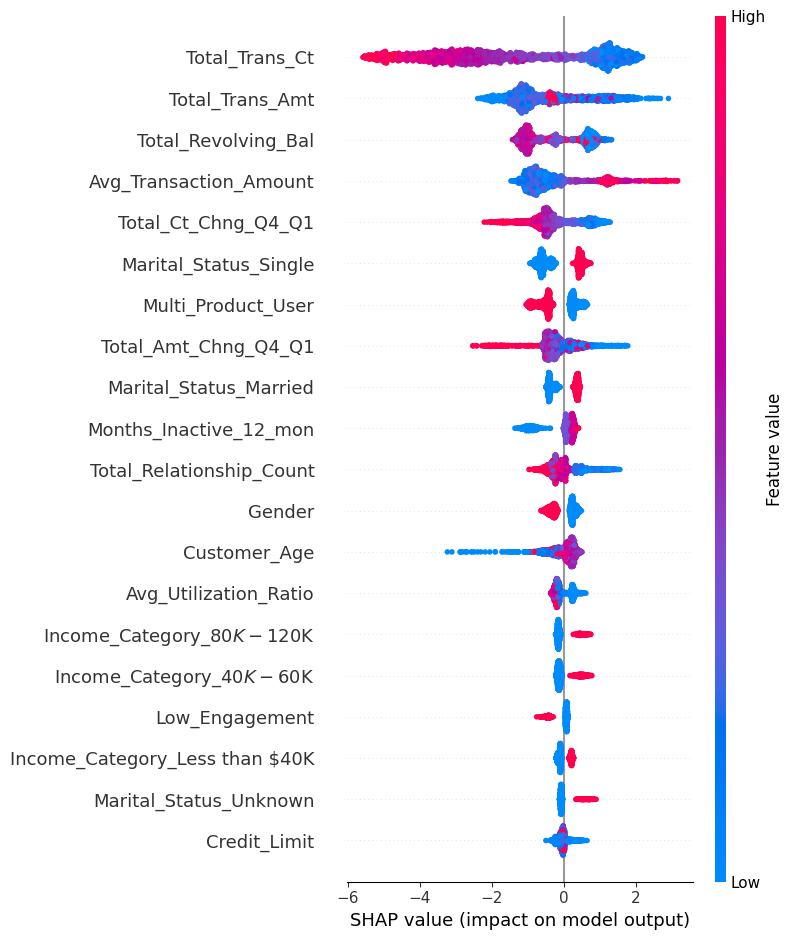

In [ ]:
# XGBoost
import shap
import matplotlib.pyplot as plt


# Use TreeExplainer for tree-based models like XGBoost
explainer = shap.TreeExplainer(bst)

# Calculate SHAP values for the full test set
shap_values = explainer.shap_values(X_test_selected)

shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features_xgb)


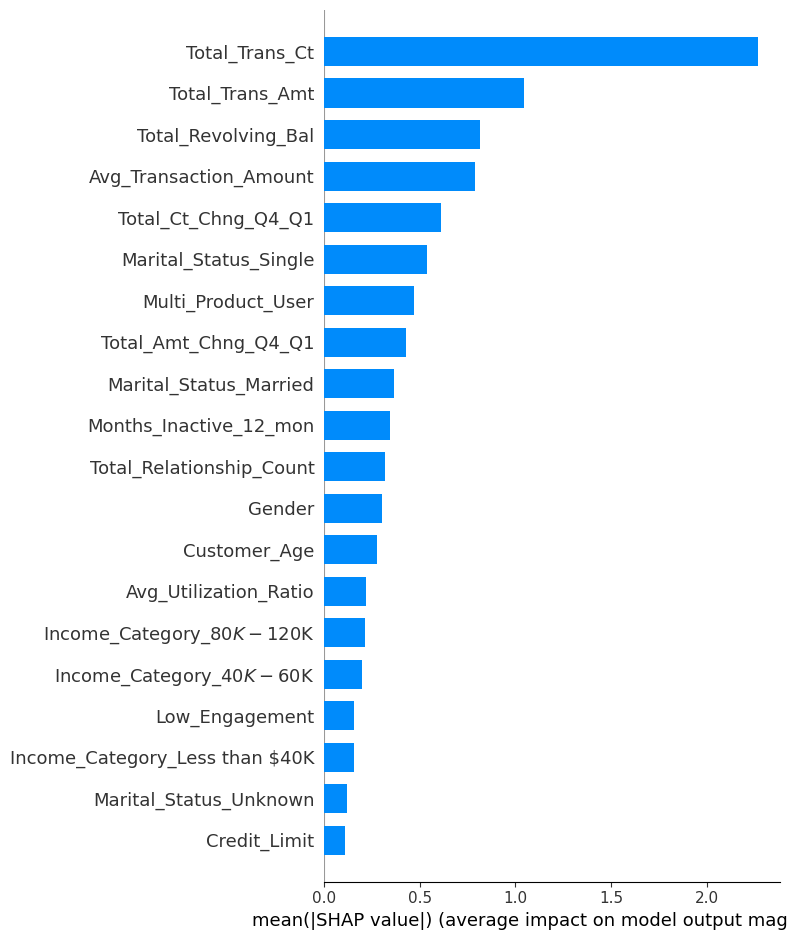

In [ ]:
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features_xgb, plot_type="bar")


## LightGBM

In [18]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

print("\n" + "="*80)
print("3. LIGHTGBM ALGORITHM")
print("="*80)

# --- RFECV Feature Selection ---
print("\n--- RFECV Feature Selection ---")
rfecv_lgb = RFECV(
    estimator=lgb.LGBMClassifier(random_state=42, n_estimators=100, verbose=-1),
    step=1,
    cv=cv,
    scoring='recall',
    min_features_to_select=5,
    n_jobs=-1
)
rfecv_lgb.fit(X_train_smote, y_train_smote)

selected_features_lgb = X_train_smote.columns[rfecv_lgb.support_].tolist()
print(f"Optimal features selected: {rfecv_lgb.n_features_}")
print(f"Best CV recall: {max(rfecv_lgb.cv_results_['mean_test_score']):.4f}")
print(f"Selected features: {selected_features_lgb}")

# --- Prepare data with selected features ---
X_train_lgb = rfecv_lgb.transform(X_train_smote)
X_test_lgb = rfecv_lgb.transform(X_test)

# --- Hyperparameter tuning with RandomizedSearchCV ---
param_dist_lgb = {
    'num_leaves': [15, 31, 50, 70],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

lgb_base = lgb.LGBMClassifier(random_state=42, verbose=-1)

random_search_lgb = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist_lgb,
    n_iter=25,
    scoring='recall',
    cv=cv,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit on selected training data
random_search_lgb.fit(X_train_lgb, y_train_smote)

# Best tuned model
best_lgb_model = random_search_lgb.best_estimator_

print("\nBest Hyperparameters for LightGBM:")
print(random_search_lgb.best_params_)

# --- Final Evaluation on Test Set ---
y_pred_lgb = best_lgb_model.predict(X_test_lgb)
y_pred_proba_lgb = best_lgb_model.predict_proba(X_test_lgb)[:, 1]

print("\n--- Final Tuned Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")

print("\n--- LIGHTGBM CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred_lgb))

# --- Store Results ---
all_results['LightGBM_Tuned'] = {
    'features': rfecv_lgb.n_features_,
    'cv_recall': random_search_lgb.best_score_,
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'precision': precision_score(y_test, y_pred_lgb),
    'recall': recall_score(y_test, y_pred_lgb),
    'f1': f1_score(y_test, y_pred_lgb),
    'auc': roc_auc_score(y_test, y_pred_proba_lgb),
    'selected_features': selected_features_lgb,
    'best_params': random_search_lgb.best_params_
}



3. LIGHTGBM ALGORITHM

--- RFECV Feature Selection ---
Optimal features selected: 18
Best CV recall: 0.9888
Selected features: ['Customer_Age', 'Gender', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Avg_Transaction_Amount', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Unknown']
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Hyperparameters for LightGBM:
{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 50, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

--- Final Tuned Model Performance ---
Accuracy: 0.9724
Precision: 0.9243
Recall: 0.9015
F1-Score: 0.9128
AUC-ROC: 0.9925

--- LIGHTGBM CLASSIFICATION REPORT ---
              precision    recall  

In [ ]:
!pip install --upgrade lightgbm




In [ ]:
import lightgbm as lgb
print(lgb.__version__)


4.6.0


In [ ]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assume these are your preprocessed datasets with selected features:
# X_train_lgb, y_train_smote -- oversampled, feature-selected training data
# X_test_lgb, y_test         -- test data with selected features

# 1. Split training data into train and validation subsets for early stopping
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_lgb,
    y_train_smote,
    test_size=0.1,
    stratify=y_train_smote,
    random_state=42
)

# 2. Define best hyperparameters from tuning
best_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 50,
    'max_depth': 5,
    'learning_rate': 0.1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.5,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1
}

# 3. Initialize LightGBM classifier
model = lgb.LGBMClassifier(
    **best_params,
    n_estimators=10000,  # large value, early stopping will pick the best boosting round
    n_jobs=-1
)

# 4. Fit with early stopping using the 'callbacks' parameter for LightGBM 4.6+
model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val_sub, y_val_sub)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=50)],
)

print(f"\nBest iteration: {model.best_iteration_}")

# 5. Define helper function to evaluate and print metrics
def evaluate_model(clf, X, y_true, dataset_name):
    y_proba = clf.predict_proba(X)[:, 1]
    y_pred = clf.predict(X)
    print(f"\n--- {dataset_name} Classification Report ---")
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, y_proba)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{dataset_name} Metrics -> Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | "
          f"Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
    return y_pred, y_proba

# 6. Evaluate on train, validation, and test sets
evaluate_model(model, X_train_sub, y_train_sub, "Training Subset")
evaluate_model(model, X_val_sub, y_val_sub, "Validation Subset")
evaluate_model(model, X_test_lgb, y_test, "Test Set")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[503]	valid_0's auc: 0.999083

Best iteration: 503

--- Training Subset Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6119
           1       1.00      1.00      1.00      6119

    accuracy                           1.00     12238
   macro avg       1.00      1.00      1.00     12238
weighted avg       1.00      1.00      1.00     12238

Training Subset Metrics -> Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | AUC: 1.0000

--- Validation Subset Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       680
           1       0.98      0.99      0.99       680

    accuracy                           0.99      1360
   macro avg       0.99      0.99      0.99      1360
weighted avg       0.99      0.99      0.99      1

(array([0, 0, 0, ..., 1, 0, 0]),
 array([6.71065438e-05, 5.65900388e-04, 1.11337770e-01, ...,
        9.99885370e-01, 1.92421567e-06, 3.24326848e-06]))

In [ ]:
# above model is overfitting

In [19]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assume your data with selected features:
# X_train_lgb, y_train_smote: oversampled training data (feature-selected)
# X_test_lgb, y_test: test data with selected features

# 1. Split training data into train and validation for early stopping
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_lgb,
    y_train_smote,
    test_size=0.1,
    stratify=y_train_smote,
    random_state=42
)

# 2. Updated hyperparameters for stronger regularization and less complexity
best_params_updated = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,              # reduced from 50 to limit model complexity
    'max_depth': 4,                # lower depth
    'learning_rate': 0.01,         # lower learning rate for smoother training
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,      # slightly less than 1.0 for more feature randomness
    'reg_alpha': 1.0,              # increased L1 regularization
    'reg_lambda': 3.0,             # increased L2 regularization
    'random_state': 42,
    'verbose': -1
}

# 3. Initialize LightGBM classifier
model = lgb.LGBMClassifier(
    **best_params_updated,
    n_estimators=20000,  # large to let early stopping decide best iteration
    n_jobs=-1
)

# 4. Train with early stopping and logging callbacks (no verbose arg in fit)
model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val_sub, y_val_sub)],
    eval_metric='auc',
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)

print(f"\nBest iteration: {model.best_iteration_}")

# 5. Evaluation helper function
def evaluate_model(clf, X, y_true, name):
    y_proba = clf.predict_proba(X)[:, 1]
    y_pred = clf.predict(X)
    print(f"\n--- {name} Classification Report ---")
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, y_proba)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{name} Metrics -> Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
    return y_pred, y_proba

# 6. Evaluate on train, validation, and test splits
evaluate_model(model, X_train_sub, y_train_sub, "Training Subset")
evaluate_model(model, X_val_sub, y_val_sub, "Validation Subset")
evaluate_model(model, X_test_lgb, y_test, "Test Set")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.985994
[200]	valid_0's auc: 0.991166
[300]	valid_0's auc: 0.993512
[400]	valid_0's auc: 0.994996
[500]	valid_0's auc: 0.99583
[600]	valid_0's auc: 0.996425
[700]	valid_0's auc: 0.99675
[800]	valid_0's auc: 0.997135
[900]	valid_0's auc: 0.997344
[1000]	valid_0's auc: 0.997496
[1100]	valid_0's auc: 0.997649
[1200]	valid_0's auc: 0.997747
[1300]	valid_0's auc: 0.997874
[1400]	valid_0's auc: 0.997987
[1500]	valid_0's auc: 0.998049
[1600]	valid_0's auc: 0.998114
[1700]	valid_0's auc: 0.998147
[1800]	valid_0's auc: 0.998196
[1900]	valid_0's auc: 0.998242
[2000]	valid_0's auc: 0.998276
[2100]	valid_0's auc: 0.9983
[2200]	valid_0's auc: 0.998322
[2300]	valid_0's auc: 0.998348
[2400]	valid_0's auc: 0.998391
[2500]	valid_0's auc: 0.99841
[2600]	valid_0's auc: 0.99843
[2700]	valid_0's auc: 0.998436
[2800]	valid_0's auc: 0.998478
[2900]	valid_0's auc: 0.998521
[3000]	valid_0's auc: 0.998542
[3100]	valid_0's auc: 0

(array([0, 0, 0, ..., 1, 0, 0]),
 array([1.23930530e-03, 6.00962032e-03, 1.40109242e-01, ...,
        9.99054385e-01, 1.18657419e-04, 1.13758526e-04]))

### SHAP LightGBM

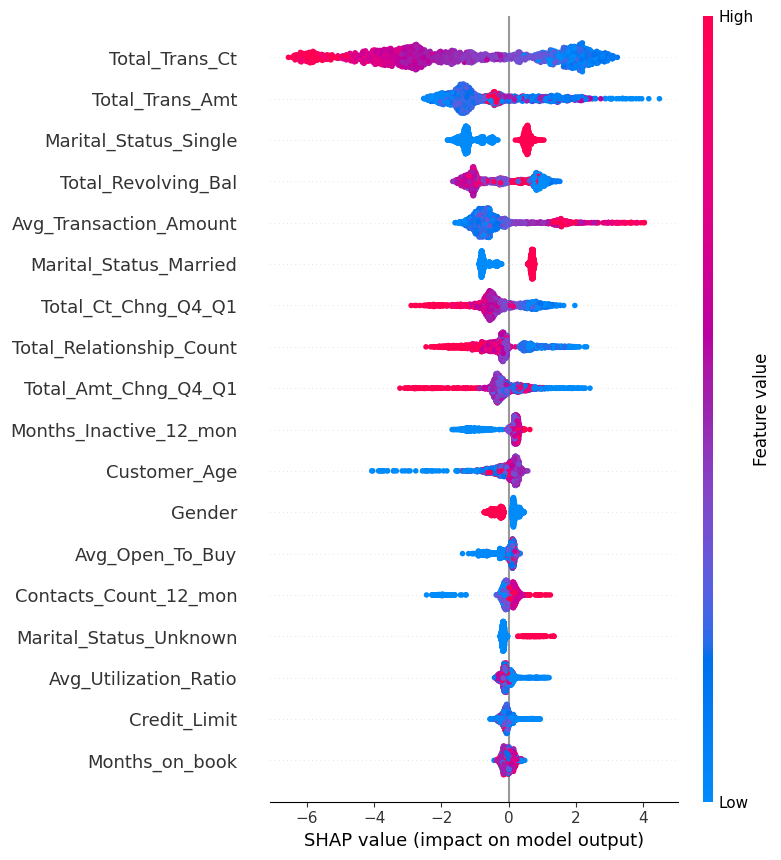

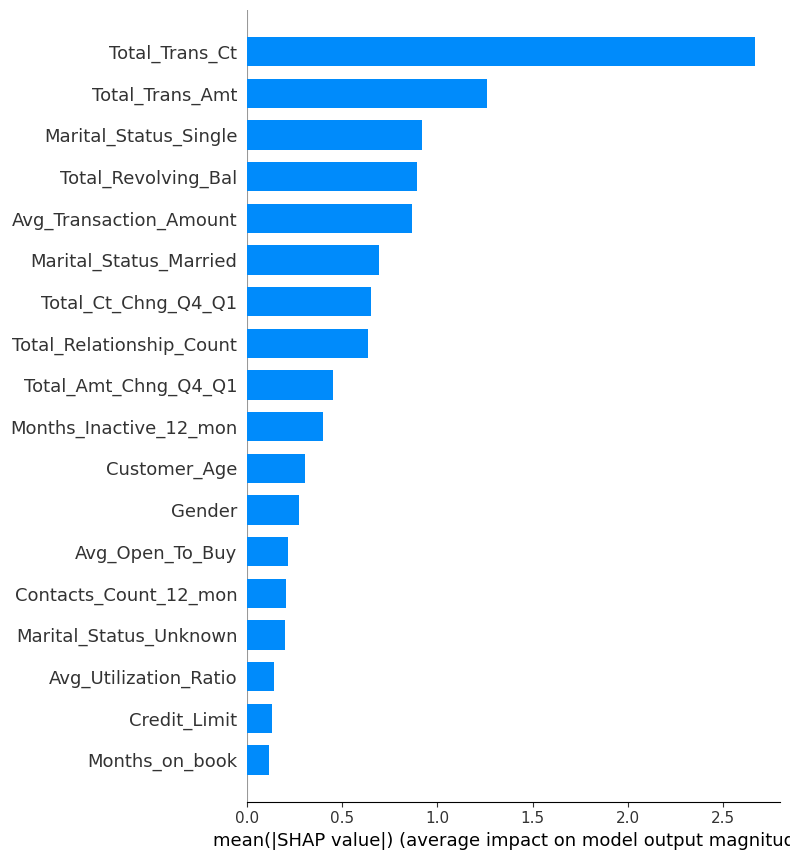

In [ ]:
import shap
import matplotlib.pyplot as plt

# If X_test_lgb is a numpy array without column names,
# convert it into a DataFrame with feature names for better plots:
import pandas as pd

X_test_df = pd.DataFrame(X_test_lgb, columns=selected_features_lgb)

# Create SHAP TreeExplainer for the LightGBM model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test_df)
shap.summary_plot(shap_values, X_test_df, plot_type="dot")
shap.summary_plot(shap_values, X_test_df, plot_type="bar")


In [ ]:
#

# Save the trained model
model.booster_.save_model('lightgbm_churn_model.txt')
# Load the saved model
loaded_model = lgb.Booster(model_file='lightgbm_churn_model.txt')
# Predict probabilities
y_test_proba = loaded_model.predict(X_test_lgb)

# Convert probabilities to class predictions (threshold = 0.5)
y_test_pred = (y_test_proba >= 0.5).astype(int)


In [ ]:
y_test_pred

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
X_train_lgb

array([[36.,  0., 24., ...,  1.,  0.,  0.],
       [44.,  1., 36., ...,  0.,  1.,  0.],
       [46.,  1., 30., ...,  1.,  0.,  0.],
       ...,
       [54.,  1., 36., ...,  1.,  1.,  0.],
       [51.,  0., 38., ...,  1.,  1.,  0.],
       [40.,  0., 25., ...,  1.,  0.,  0.]])

In [ ]:
X_train_lgb.shape

(13598, 18)

In [ ]:
selected_features_lgb = X_train_smote.columns[rfecv_lgb.support_].tolist()
selected_features_lgb

['Customer_Age',
 'Gender',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Avg_Transaction_Amount',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Unknown']

In [ ]:
import joblib

# Paths to save
model_path = "/content/drive/My Drive/MRP/lgbm_model.pkl"
scaler_path = "/content/drive/My Drive/MRP/scaler.pkl"
features_path = "/content/drive/My Drive/MRP/selected_features.pkl"

# Save model, scaler, and feature list
joblib.dump(best_lgb_model, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(selected_features_lgb, features_path)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Scaler saved to: {scaler_path}")
print(f"✅ Selected features saved to: {features_path}")


✅ Model saved to: /content/drive/My Drive/MRP/lgbm_model.pkl
✅ Scaler saved to: /content/drive/My Drive/MRP/scaler.pkl
✅ Selected features saved to: /content/drive/My Drive/MRP/selected_features.pkl


In [ ]:
original_features_names = X_train_smote.columns.tolist()  # or the exact list you used for your full dataset
original_features_names

['Customer_Age',
 'Gender',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'High_Utilization',
 'Activity_Decline',
 'Low_Engagement',
 'Avg_Transaction_Amount',
 'Credit_Dependency',
 'High_Value_Customer',
 'Multi_Product_User',
 'Education_Level_Doctorate',
 'Education_Level_Graduate',
 'Education_Level_High School',
 'Education_Level_Post-Graduate',
 'Education_Level_Uneducated',
 'Education_Level_Unknown',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Unknown',
 'Income_Category_$40K - $60K',
 'Income_Category_$60K - $80K',
 'Income_Category_$80K - $120K',
 'Income_Category_Less than $40K',
 'Income_Category_Unknown',
 'Card_Category_Gold',
 'Card_Category_Platinum',
 'Card_Category_Silver']

In [ ]:
import joblib

# Full original feature list (before RFECV selection)
full_feature_list = X_train_smote.columns.tolist()

# Save the list so we can load it later for predictions
joblib.dump(full_feature_list, "/content/drive/My Drive/MRP/full_features.pkl")

print("✅ Full feature list saved to /content/drive/My Drive/MRP/full_features.pkl")


✅ Full feature list saved to /content/drive/My Drive/MRP/full_features.pkl


| Model     | Accuracy | AUC | Recall | F1score  |
|-----------|-----|-----|-----|-----|
| CatBoost  | 97 | 99 | 86 | 89 |
| XGBoost   | 96 | 99 | 86 | 89 |
| **LightGBM**  | **97** | **99** | **90** | **90** |

test

In [27]:
import pandas as pd
import joblib

# ---------------------------
# Load saved artifacts
# ---------------------------
model_path = "/content/drive/My Drive/MRP/lgbm_model.pkl"
full_features_path = "/content/drive/My Drive/MRP/full_features.pkl"
selected_features_path = "/content/drive/My Drive/MRP/selected_features.pkl"

loaded_model = joblib.load(model_path)
full_features = joblib.load(full_features_path)
selected_features = joblib.load(selected_features_path)

print(f"✅ Loaded model and feature lists.")

# ---------------------------
# Prediction function (no scaling)
# ---------------------------
def predict_churn_noscale(raw_df):
    """
    raw_df: pd.DataFrame with raw input (df_1 style)
    returns: tuple (predicted_class, churn_probability)
    """
    df = raw_df.copy()

    # 1. Feature Engineering
    df['High_Utilization'] = (df['Avg_Utilization_Ratio'] > 0.7).astype(int)
    df['Activity_Decline'] = ((df['Total_Ct_Chng_Q4_Q1'] < 0.7) |
                              (df['Total_Amt_Chng_Q4_Q1'] < 0.7)).astype(int)
    df['Low_Engagement'] = ((df['Months_Inactive_12_mon'] > 2) &
                            (df['Contacts_Count_12_mon'] < 3)).astype(int)
    df['Avg_Transaction_Amount'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']
    df['Credit_Dependency'] = df['Total_Revolving_Bal'] / df['Credit_Limit']
    df['High_Value_Customer'] = (df['Total_Trans_Amt'] >
                                 df['Total_Trans_Amt'].quantile(0.75)).astype(int)
    df['Multi_Product_User'] = (df['Total_Relationship_Count'] > 3).astype(int)

    # 2. One-hot encode categorical columns
    categorical_cols = ['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
    df_encoded = pd.get_dummies(df, columns=categorical_cols)

    # 3. Align with full_features (missing columns = 0)
    df_aligned = df_encoded.reindex(columns=full_features, fill_value=0)

    # 4. Select only RFECV features
    X_new = df_aligned[selected_features].values

    # 5. Predict
    prob = loaded_model.predict_proba(X_new)[:, 1][0]
    pred_class = int(prob >= 0.5)

    return pred_class, prob

# ---------------------------
# Example usage
# ---------------------------
example_input = pd.DataFrame([{
    "Customer_Age": 45,
    "Gender": 1,
    "Dependent_count": 3,
    "Education_Level": "High School",
    "Marital_Status": "Married",
    "Income_Category": "$60K - $80K",
    "Card_Category": "Blue",
    "Months_on_book": 39,
    "Total_Relationship_Count": 5,
    "Months_Inactive_12_mon": 1,
    "Contacts_Count_12_mon": 3,
    "Credit_Limit": 12691.0,
    "Total_Revolving_Bal": 777,
    "Avg_Open_To_Buy": 11914.0,
    "Total_Amt_Chng_Q4_Q1": 1.335,
    "Total_Trans_Amt": 1144,
    "Total_Trans_Ct": 42,
    "Total_Ct_Chng_Q4_Q1": 1.625,
    "Avg_Utilization_Ratio": 0.061
}])

pred_class, churn_prob = predict_churn_noscale(example_input)
print("Predicted class:", pred_class)
print("Churn probability:", churn_prob)


✅ Loaded model and feature lists.
Predicted class: 0
Churn probability: 1.88174433276408e-05


In [29]:
import pandas as pd
import joblib

# ---------------------------
# Load saved artifacts
# ---------------------------
model_path = "/content/drive/My Drive/MRP/lgbm_model.pkl"
full_features_path = "/content/drive/My Drive/MRP/full_features.pkl"
selected_features_path = "/content/drive/My Drive/MRP/selected_features.pkl"

loaded_model = joblib.load(model_path)
full_features = joblib.load(full_features_path)
selected_features = joblib.load(selected_features_path)

print(f"✅ Loaded model and feature lists.")

# ---------------------------
# Prediction function (no scaling)
# ---------------------------
def predict_churn_noscale(raw_df):
    """
    raw_df: pd.DataFrame with raw input (df_1 style)
    returns: tuple (predicted_class, churn_probability)
    """
    df = raw_df.copy()

    # 1. Feature Engineering
    df['High_Utilization'] = (df['Avg_Utilization_Ratio'] > 0.7).astype(int)
    df['Activity_Decline'] = ((df['Total_Ct_Chng_Q4_Q1'] < 0.7) |
                              (df['Total_Amt_Chng_Q4_Q1'] < 0.7)).astype(int)
    df['Low_Engagement'] = ((df['Months_Inactive_12_mon'] > 2) &
                            (df['Contacts_Count_12_mon'] < 3)).astype(int)
    df['Avg_Transaction_Amount'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']
    df['Credit_Dependency'] = df['Total_Revolving_Bal'] / df['Credit_Limit']
    df['High_Value_Customer'] = (df['Total_Trans_Amt'] >
                                 df['Total_Trans_Amt'].quantile(0.75)).astype(int)
    df['Multi_Product_User'] = (df['Total_Relationship_Count'] > 3).astype(int)

    # 2. One-hot encode categorical columns
    categorical_cols = ['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
    df_encoded = pd.get_dummies(df, columns=categorical_cols)

    # 3. Align with full_features (missing columns = 0)
    df_aligned = df_encoded.reindex(columns=full_features, fill_value=0)

    # 4. Select only RFECV features
    X_new = df_aligned[selected_features].values

    # 5. Predict
    prob = loaded_model.predict_proba(X_new)[:, 1][0]
    pred_class = int(prob >= 0.5)

    return pred_class, prob

# ---------------------------
# Example usage
# ---------------------------
example_input = pd.DataFrame([{
    "Customer_Age": 35,
    "Gender": 0,
    "Dependent_count": 0,
    "Education_Level": "Graduate",
    "Marital_Status": "Single",
    "Income_Category": "Less than $40K",
    "Card_Category": "Blue",
    "Months_on_book": 10,
    "Total_Relationship_Count": 1,
    "Months_Inactive_12_mon": 5,
    "Contacts_Count_12_mon": 0,
    "Credit_Limit": 3000.0,
    "Total_Revolving_Bal": 2800,
    "Avg_Open_To_Buy": 200.0,
    "Total_Amt_Chng_Q4_Q1": 0.5,
    "Total_Trans_Amt": 150,
    "Total_Trans_Ct": 5,
    "Total_Ct_Chng_Q4_Q1": 0.4,
    "Avg_Utilization_Ratio": 0.93
}])
pred_class, churn_prob = predict_churn_noscale(example_input)
print("Predicted class:", pred_class)
print("Churn probability:", churn_prob)


✅ Loaded model and feature lists.
Predicted class: 1
Churn probability: 0.9743445409091656
